In [2]:
!pip install numpy pandas matplotlib tensorflow ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00


In [3]:
!pip install kagglehub

In [4]:
import kagglehub
cars_image_dataset_path = kagglehub.dataset_download('kshitij192/cars-image-dataset')

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from IPython.display import FileLink

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cars-image-dataset/Cars Dataset/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cars-image-dataset/Cars Dataset/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())

Found 3352 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


In [7]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Update train_datagen preprocessing_function
train_datagen.preprocessing_function = preprocess_input

base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 18,568,775 (70.83 MB)

 Trainable params: 246,791 (964.03 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [10]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 144s 930ms/step - accuracy: 0.2157 - loss: 1.9186 - val_accuracy: 0.1538 - val_loss: 4.3540 - learning_rate: 5.0000e-04
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.2920 - loss: 1.8393 - val_accuracy: 0.1550 - val_loss: 4.9563 - learning_rate: 5.0000e-04
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.2879 - loss: 1.8331 - val_accuracy: 0.1427 - val_loss: 5.4271 - learning_rate: 5.0000e-04
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.2897 - loss: 1.8223 - val_accuracy: 0.0923 - val_loss: 7.1659 - learning_rate: 5.0000e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.2922 - loss: 1.8189 - val_accuracy: 0.0923 - val_loss: 8.4272 - learning_rate: 5.0000e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2896 - loss: 1.8293
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/s

In [11]:
scores = model.evaluate(test_generator)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.0657 - loss: 5.9047
Test Loss: 4.3540
Test Accuracy: 15.38%


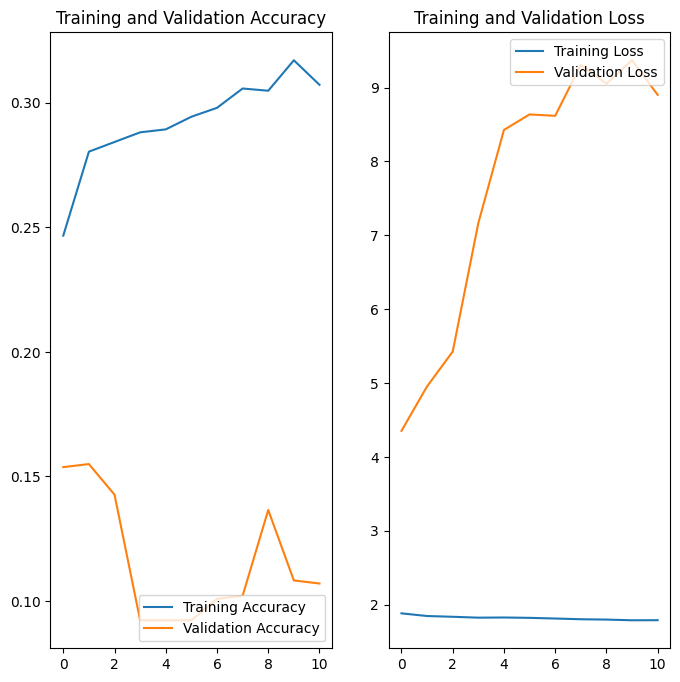

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = len(acc)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


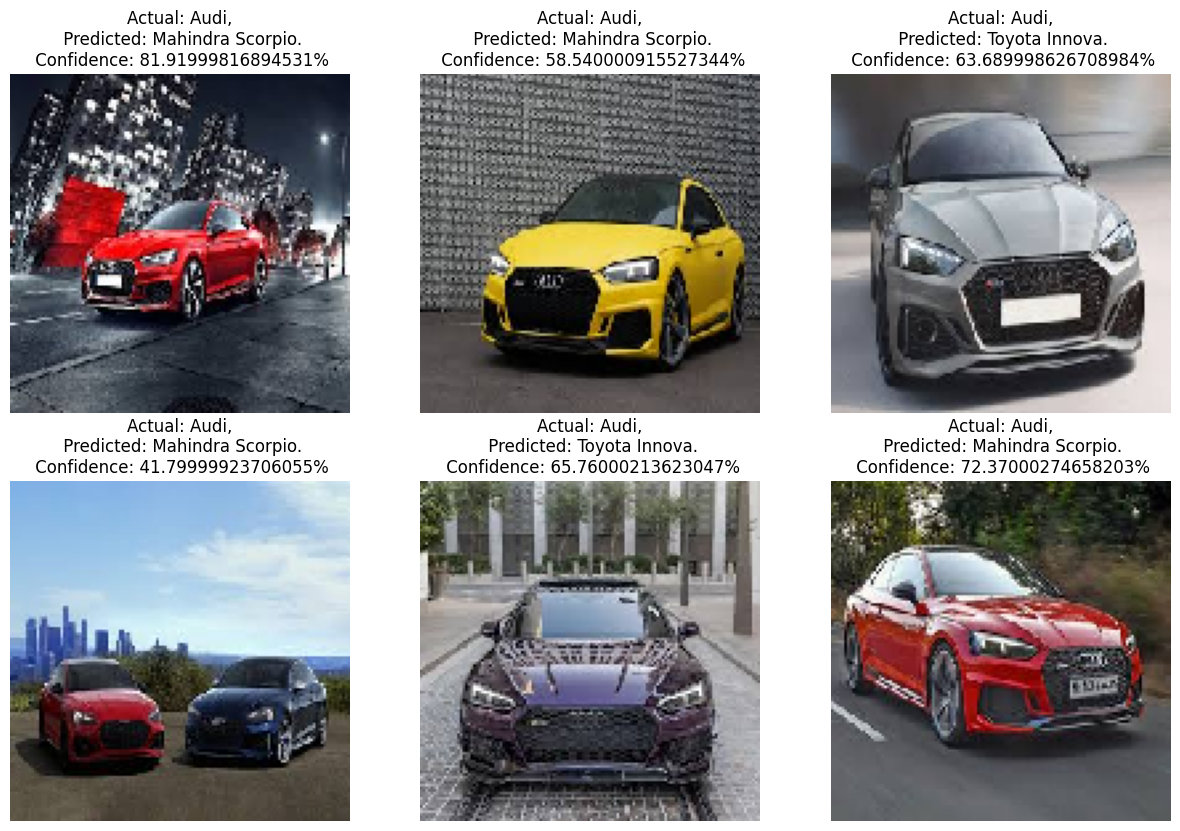

In [13]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    break

In [14]:
model.save('trained_model.h5')
FileLink('trained_model.h5')


/content/trained_model.h5

In [15]:
model.save('my_model.keras')

In [16]:
FileLink('my_model.keras')

/content/my_model.keras

In [17]:
from google.colab import files
files.download('trained_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from google.colab import files
files.download('my_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>